
# <span style="color:rgb(213,80,0)">    Predicting True Air Speed from Other Sensors</span>

This example shows how to use historical data to train a regression model that is capable of predicting the True Air Speed (TAS) of a flight from the measurements of other sensors. Such models can be useful in controls applications where it may be desirable to use a regression model as a nonlinear state estimator for a non\-observable or costly\-to\-observe state.  These types of models can also be used as surrogate models in simulations and trade\-studies, in cases where a physics\-based model is too complex to create or takes too long to simulate.

## Make sure a project is open

In [4]:
try
    prj = currentProject;
catch
    open("..\VirtualSensorModeling.prj");
    prj = currentProject;
end

## Import data from Excel

Start by reading in the data with code generated by the Import Tool. Also remove data recorded when the aircraft was stationary on the ground as that will not be useful for predicting airspeed.


In [5]:
FlightData = importFlightData("FlightData.xlsx");

In [6]:
% perform simple clean up of stationary ground data
FlightData = FlightData(FlightData.TrueAirSpeed >= 10, :);
head(FlightData)

            Time            FuelQuantity    OilPressure    OilTemperature    LatitudePosition    LongitudePosition    Altitude    ExhaustTemperature    FuelFlow    FanSpeed    TrueAirSpeed    WindDirection    WindSpeed
    ____________________    ____________    ___________    ______________    ________________    _________________    ________    __________________    ________    ________    ____________    _____________    _________

    02-Jun-2001 05:50:04       7966.8         90.354           58.805             44.891              -63.508           204             566.5             2632       90.875        100.12                0             0  
    02-Jun-2001 05:50:05         7968         90.354           58.595             44.891              -63.508           203               567             2632       90.875        100.19           -33.75        6.9727  
    02-Jun-2001 05:50:05         7968         90.354           58.595             44.891              -63.508           203

## Visualize data

We can see the flight path by viewing a `geoplot` of latitude and longitude.


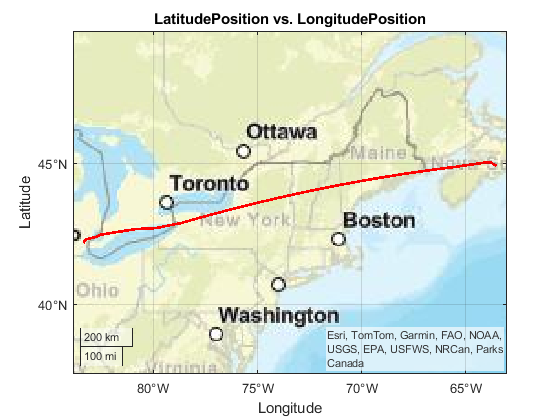

In [7]:
figure
% Specify basemap that doesn't require internet download
geobasemap darkwater
% Create geoplot of FlightData.LatitudePosition and FlightData.LongitudePosition
h = geoplot(FlightData.LatitudePosition,FlightData.LongitudePosition,"LineWidth",2,"Color","red");
geobasemap streets

% Add title
title("LatitudePosition vs. LongitudePosition")



Some of the sensors appear to have dropouts that we'll need to clean.


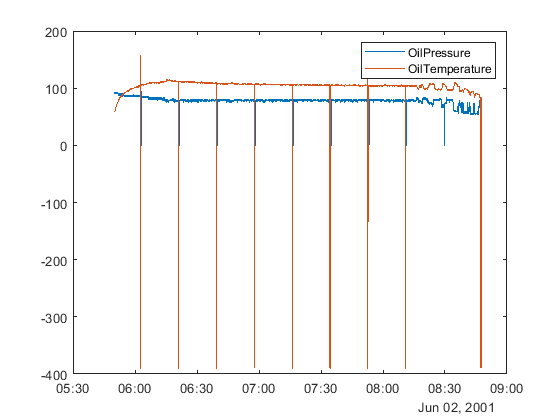

In [8]:
figure
% Create plot of FlightData.Time and FlightData.OilPressure
plot(FlightData.Time,FlightData.OilPressure,"DisplayName","OilPressure");

hold on
% Create plot of FlightData.Time and FlightData.OilTemperature
plot(FlightData.Time,FlightData.OilTemperature,"DisplayName","OilTemperature");
hold off

legend

## Clean sensor data

Use the Data Cleaner to remove the sensor dropouts for oil pressure and temperature.


In [9]:
FlightDataClean = cleanOilSensors(FlightData);


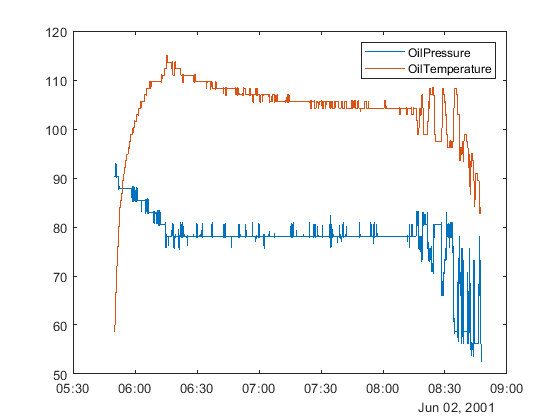

In [10]:
figure
% Create plot of FlightDataClean.Time and FlightDataClean.OilPressure
plot(FlightDataClean.Time,FlightDataClean.OilPressure,"DisplayName","OilPressure");

hold on
% Create plot of FlightDataClean.Time and FlightDataClean.OilTemperature
plot(FlightDataClean.Time,FlightDataClean.OilTemperature,"DisplayName","OilTemperature");
hold off

legend


## Model True Air Speed

We can model TAS with a regression model trained in the Regression Learner app. We'll use a bagged decision tree with default settings, which produces very accurate cross\-validated results. Normally in a machine learning workflow we'd use a separate hold\-out test set to verify results, but we'll skip that here for brevity.


In [11]:
rng(42) % reproducibility
mdl = trainTASModel(FlightDataClean)

mdl = struct with fields:
            predictFcn: @(x)ensemblePredictFcn(predictorExtractionFcn(x))
     RequiredVariables: {1x9 cell}
    RegressionEnsemble: [1x1 classreg.learning.regr.RegressionBaggedEnsemble]
                 About: 'This struct is a trained model exported from Regression Learner R2022a.'
          HowToPredict: 'To make predictions on a new table, T, use: ...'

In [12]:
PredictedAirSpeed = mdl.predictFcn(FlightDataClean);

## Model using a Python module

We can also use an existing Python module to train a similar model. We will then compare the results in the next section.


In [13]:
pyModel = py.pythonModeling.train_random_forest_regressor(FlightDataClean);
pyPredictedSpeeds = py.pythonModeling.predict_with_model(pyModel,FlightDataClean);

No module or function named 'pythonModeling'.


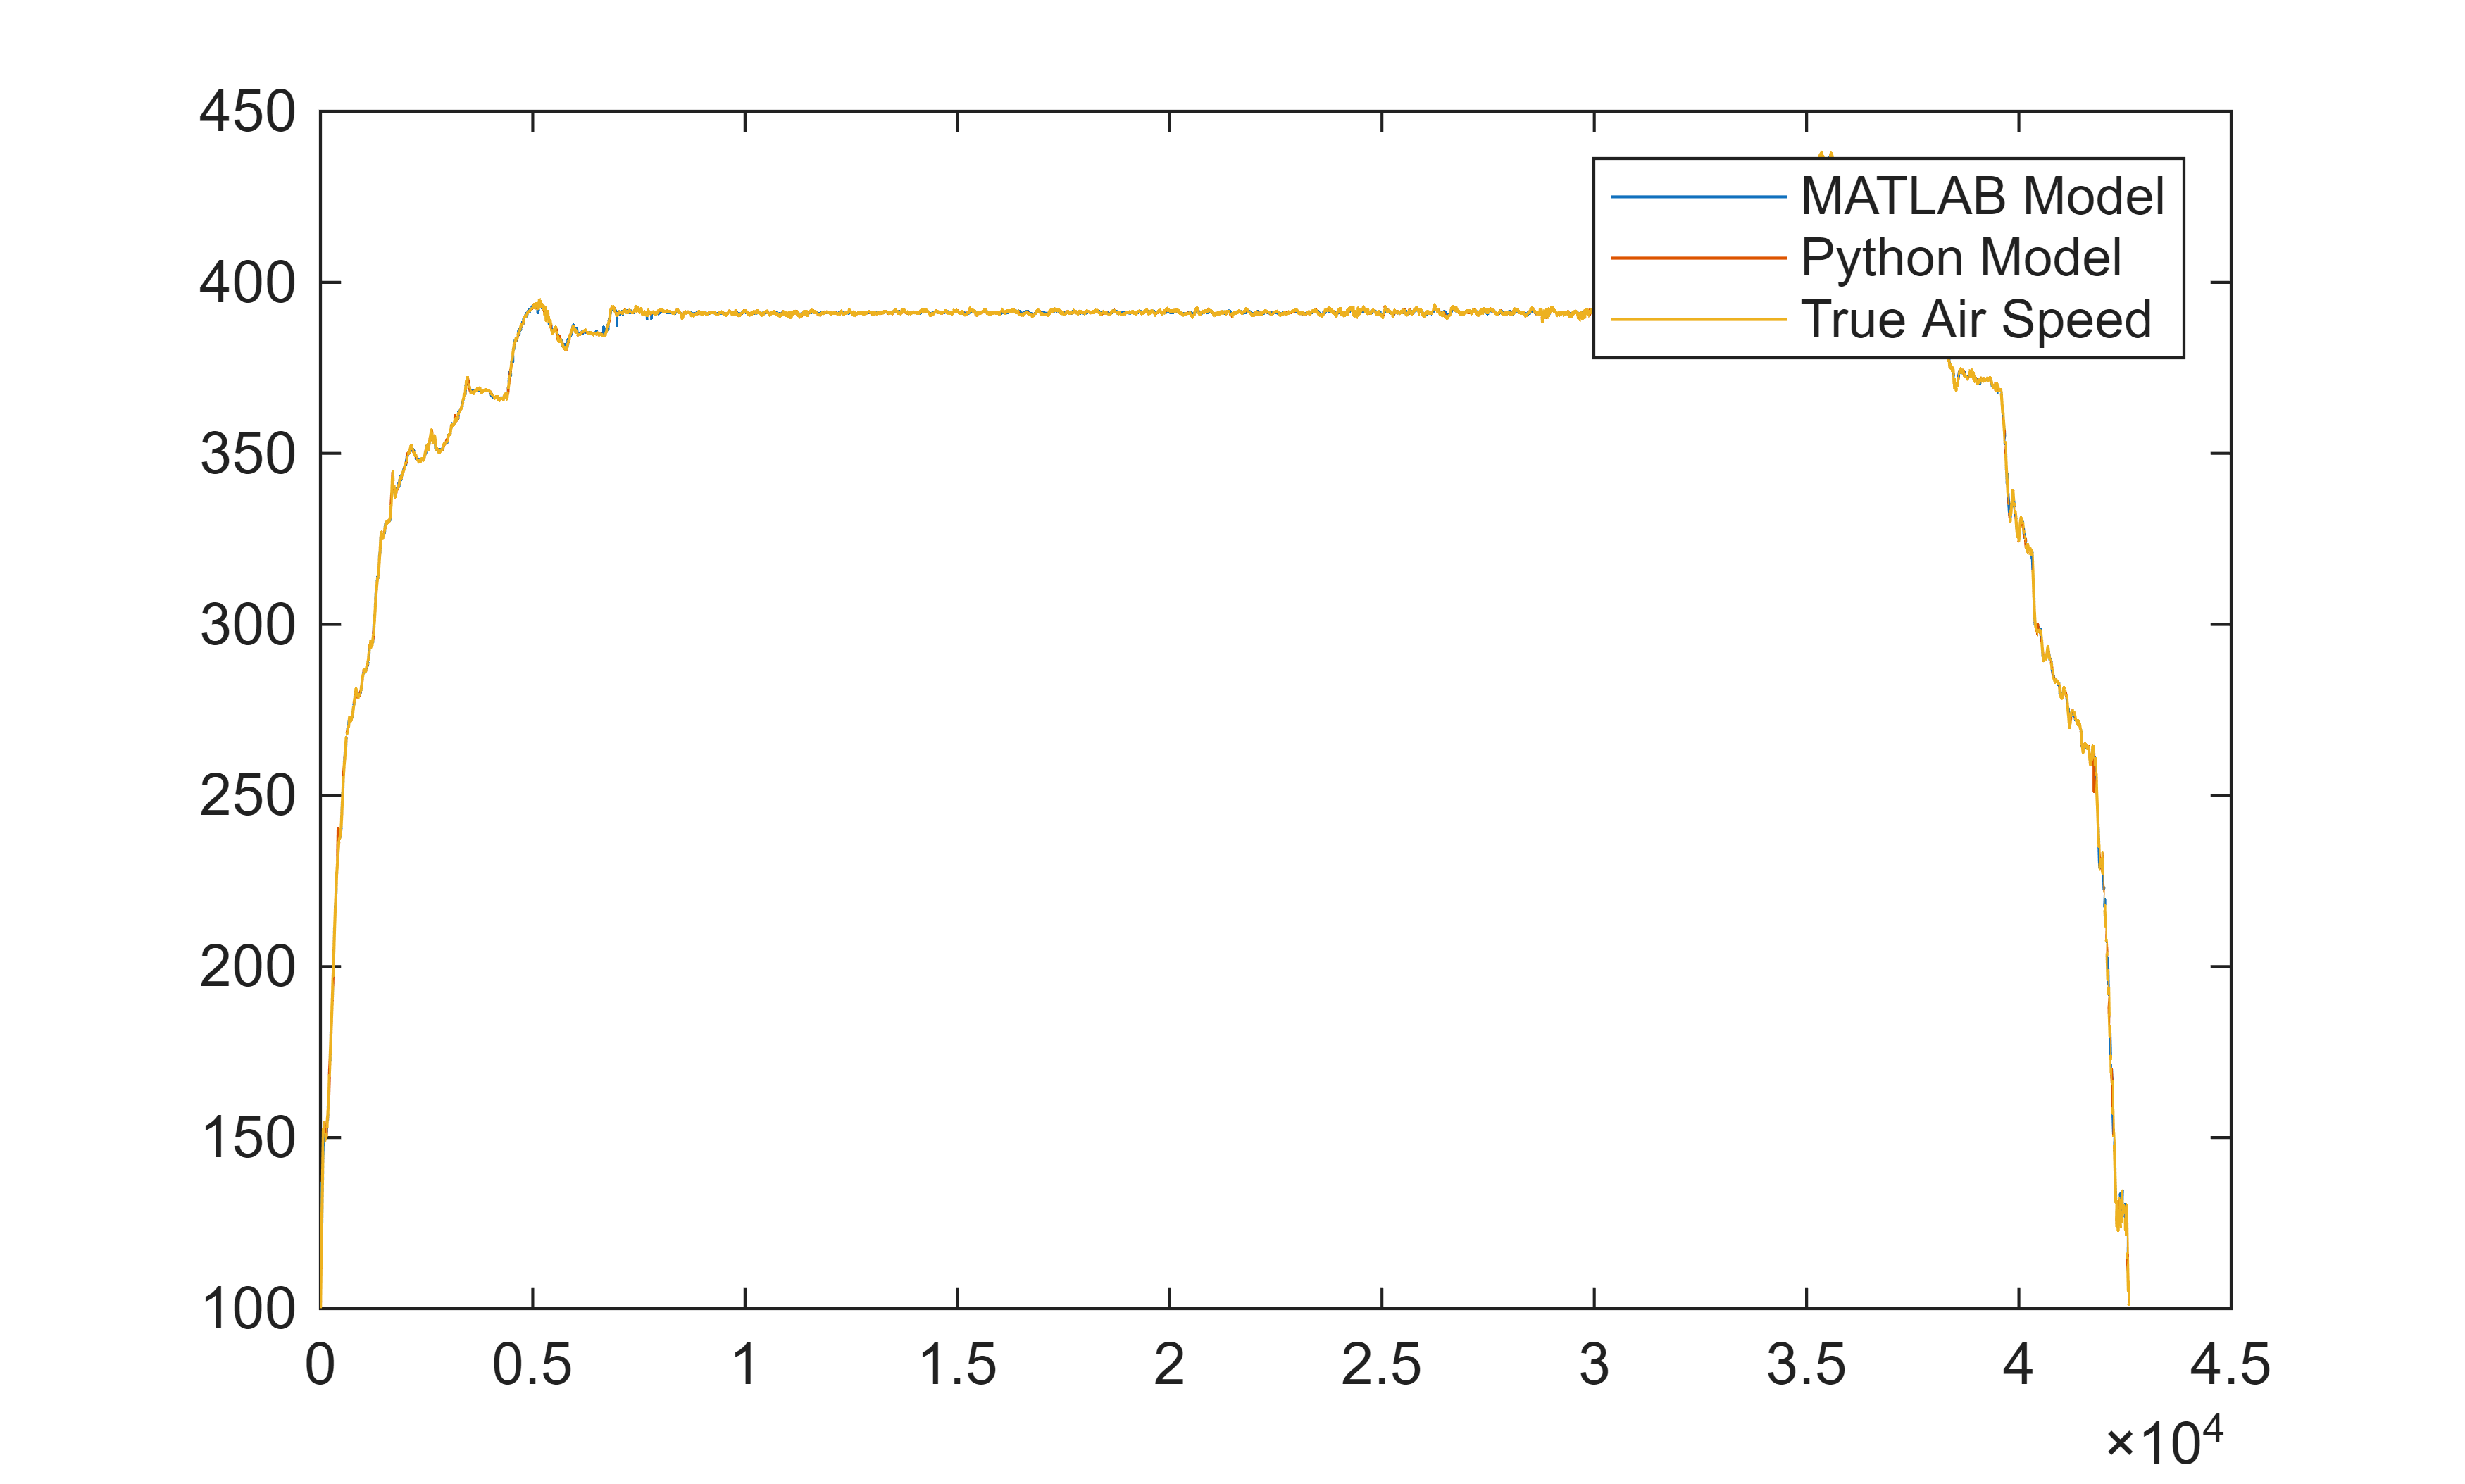

In [11]:
plot(PredictedAirSpeed)
hold on
plot(pyPredictedSpeeds)
plot(FlightDataClean.TrueAirSpeed)
legend('MATLAB Model','Python Model','True Air Speed')
hold off


## Predictor importance

Which measurements are important for making predictions? One benefit of the bagged decision tree model is it automatically provides a measure of predictor importance.


FuelFlow is the most important predictor in this case, followed by WindDirection, WindSpeed, and FanSpeed.



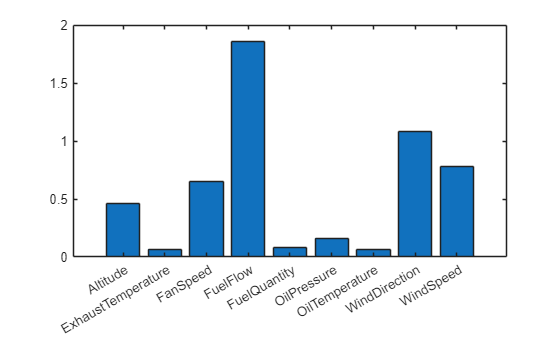

In [12]:
figure
bar(mdl.RegressionEnsemble.predictorImportance)
xticklabels(mdl.RequiredVariables)